# Prediction of Housing Prices


*Authors: Eric Luong, David Chien, Michelle Zhang*  
*Data: Ames Housing Dataset from Kaggle*  

Time flies! You have now learned and (hopefully) mastered all the skills required to build a real-world ML regression model! These skills include:

- Exploratory data analysis (EDA)
- Data pre-processing and feature engineering: scaling, imputation, encoding...
- A suite of regression models: linear regression, trees, forests, ...
- Hyperparamter tuning: CV, GridSearch...
- Model evaluation

Now it is time to deploy these skills in the real world, build your first "real" ML project, and see how you perform against other data scientists from all over the world!

We will join this active Kaggle competition to predict house prices:


https://www.kaggle.com/c/house-prices-advanced-regression-techniques

You will find the detailed description of the competition from above web site, and can download the data directly there. 

**Requirements:**

- Please use this notebook to create your code, explanation, graphs, and results just like what you did for your homework.
- Each group should create a Kaggle account and submit the prediction of your model in Kaggle. Please add "SCU_" in front of your team name so that you can check how you rank among your classmates in the Leaderboard. However, you do not have to use your real name in your team name.
- You can submit your results multiple times in Kaggle. Therefore you are encouraged to submit your model, improve, then re-submit. It is a continuous learning process.
- **Please include a screenshot of your best Kaggle submission at the bottom of this notebook showing your rank and score in the leaderboard.**
- You are also encouraged to read discussion forums to learn and get your inspiration, but code copying is strictly forbidden.
- **Honor code: again, you cannot copy code. We will check your code and you will be asked to present in class (so you need to be extremely familiar with your work)!**

In [22]:
# Import relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

In [23]:
# Load train and test data
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")


## Exploratory Data Analysis

In [24]:
# Check for missing values
train_data.isnull().sum().sort_values(ascending=False).head(20) 

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
Id                 0
dtype: int64

### Histogram for Skewness

Text(0.5, 1.0, 'SalePrice distribution')

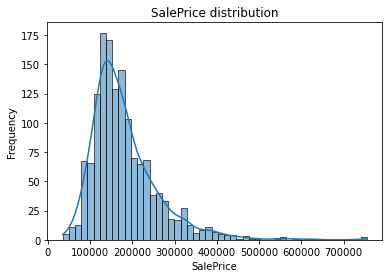

In [25]:
# Check the new distribution 
sns.histplot(train_data['SalePrice'], kde=True)

plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

In [26]:
# Skew and kurt
print("Skewness: %f" % train_data['SalePrice'].skew())
print("Kurtosis: %f" % train_data['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


Since the target variable is skewed, we will apply log transformation to it. This will help us to get a normal distribution of the target variable.

Text(0.5, 1.0, 'SalePrice distribution')

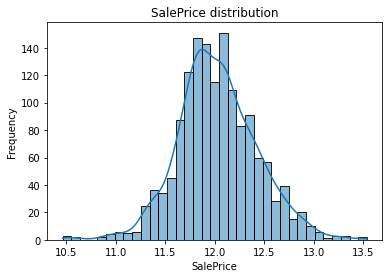

In [27]:
# Log-transform the target variable
train_data["SalePrice"] = np.log1p(train_data["SalePrice"])

# Check the new distribution 
sns.histplot(train_data['SalePrice'], kde=True)

plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

### Correlation Matrix

<AxesSubplot:>

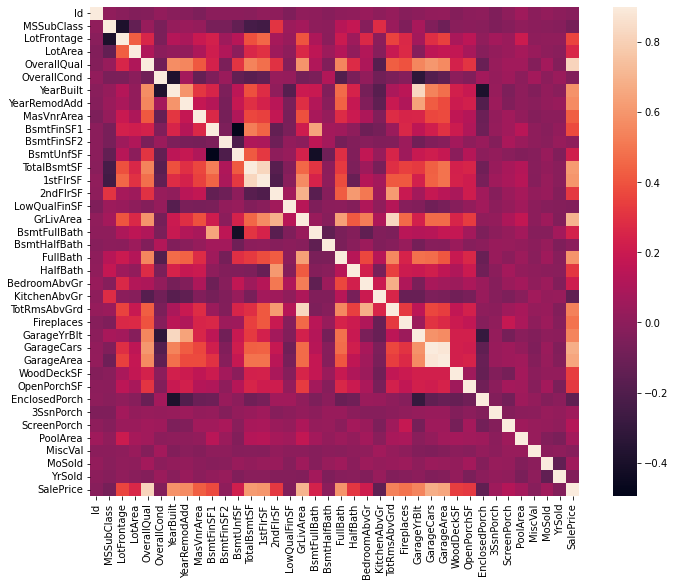

In [28]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train_data.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

<AxesSubplot:>

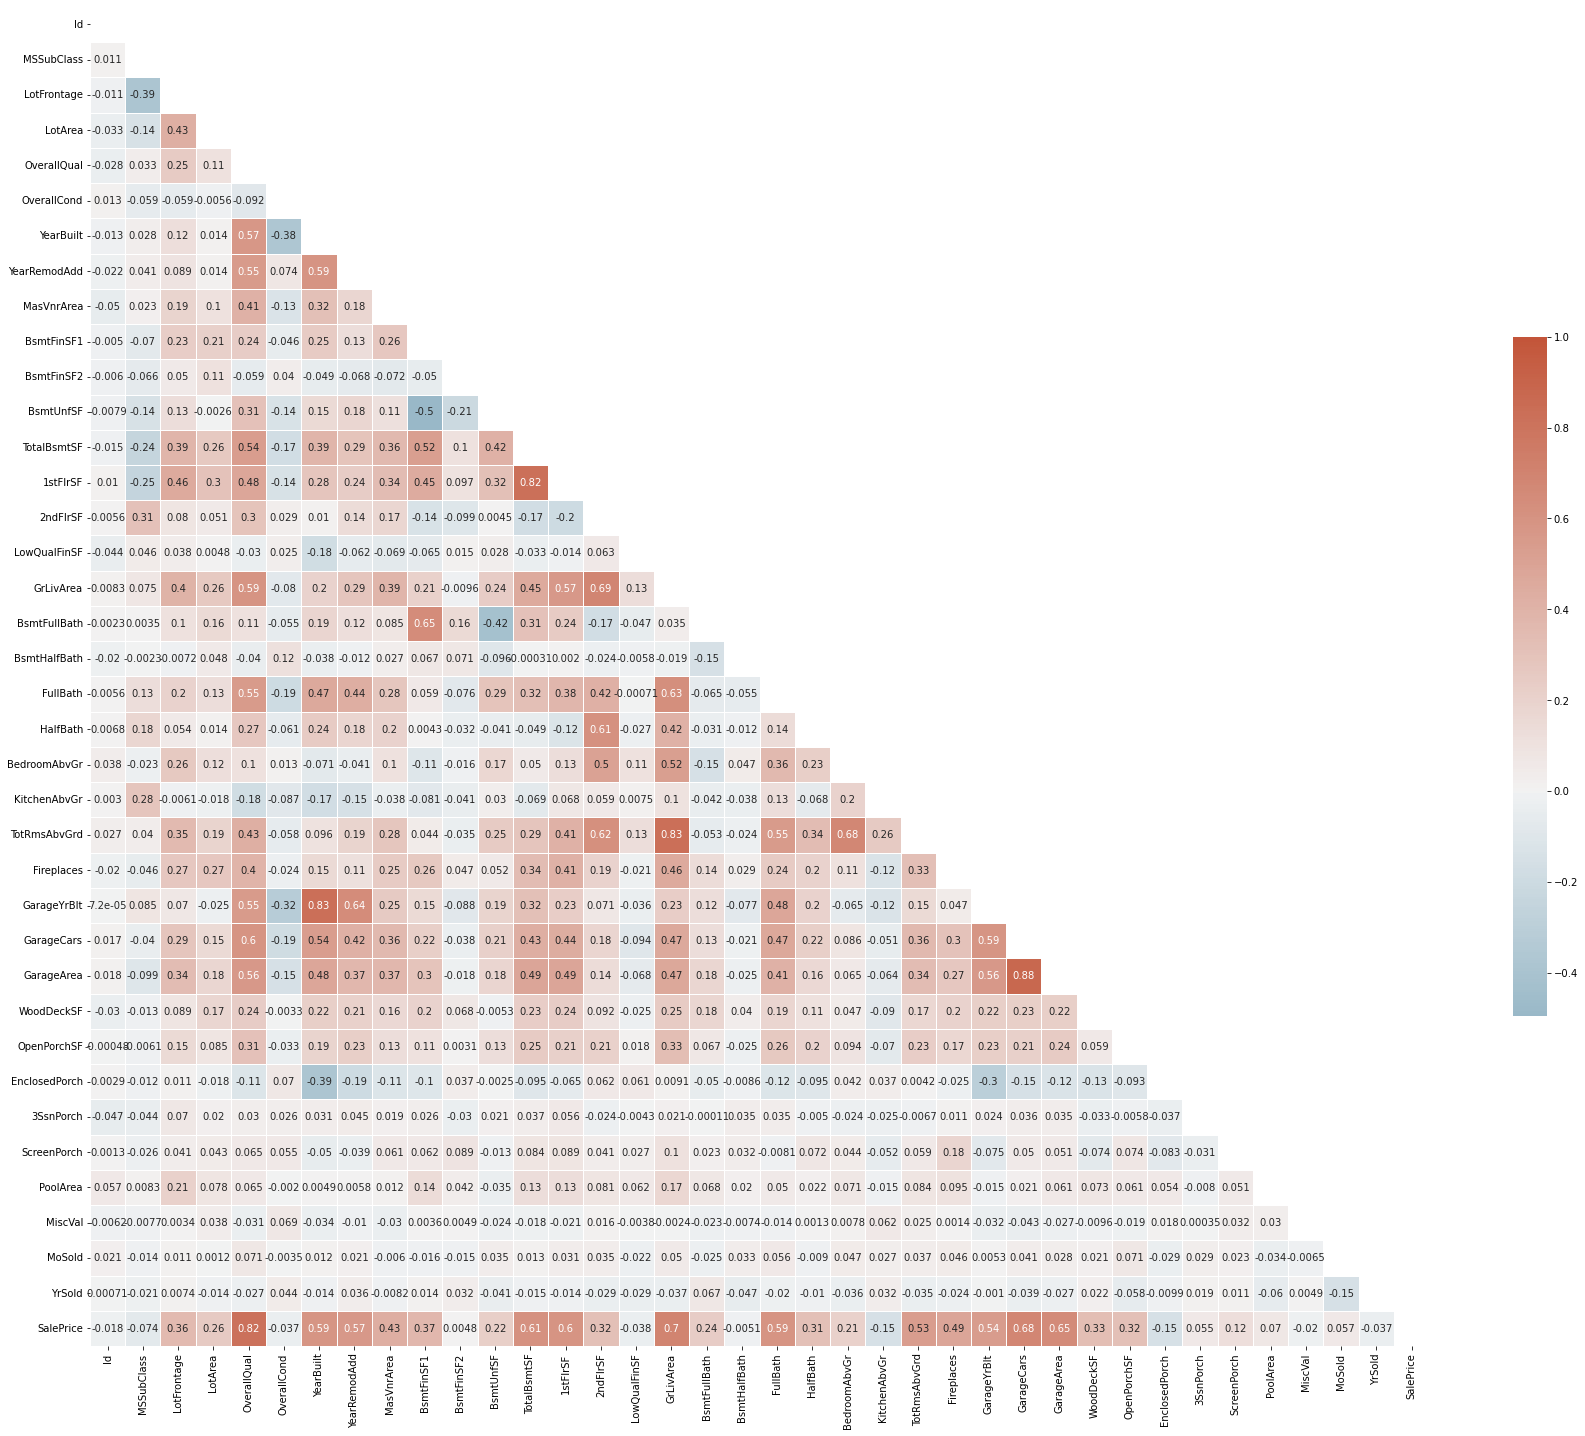

In [29]:
# Correlation Matrix

f, ax = plt.subplots(figsize=(30, 25))
mat = train_data.corr('pearson')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Analyzing Correlations

In [30]:
correlations = train_data.corr()["SalePrice"].abs().sort_values(ascending = False)
correlations.head()

SalePrice      1.000000
OverallQual    0.817185
GrLivArea      0.700927
GarageCars     0.680625
GarageArea     0.650888
Name: SalePrice, dtype: float64

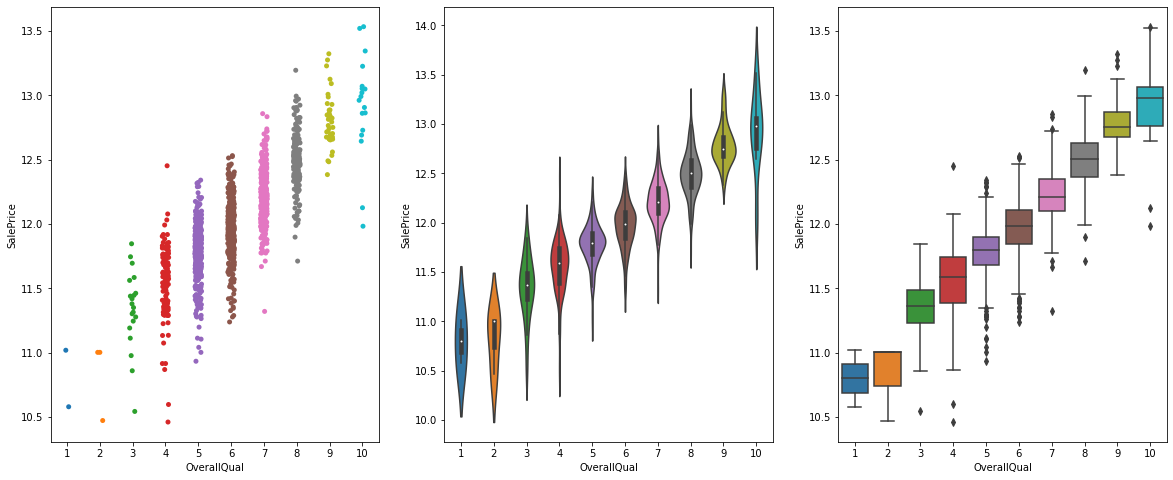

In [31]:
# OverallQuall - SalePrice [corr = 0.82]

figure, ax = plt.subplots(1,3, figsize = (20,8))
sns.stripplot(data=train_data, x = 'OverallQual', y='SalePrice', ax = ax[0])
sns.violinplot(data=train_data, x = 'OverallQual', y='SalePrice', ax = ax[1])
sns.boxplot(data=train_data, x = 'OverallQual', y='SalePrice', ax = ax[2])
plt.show()

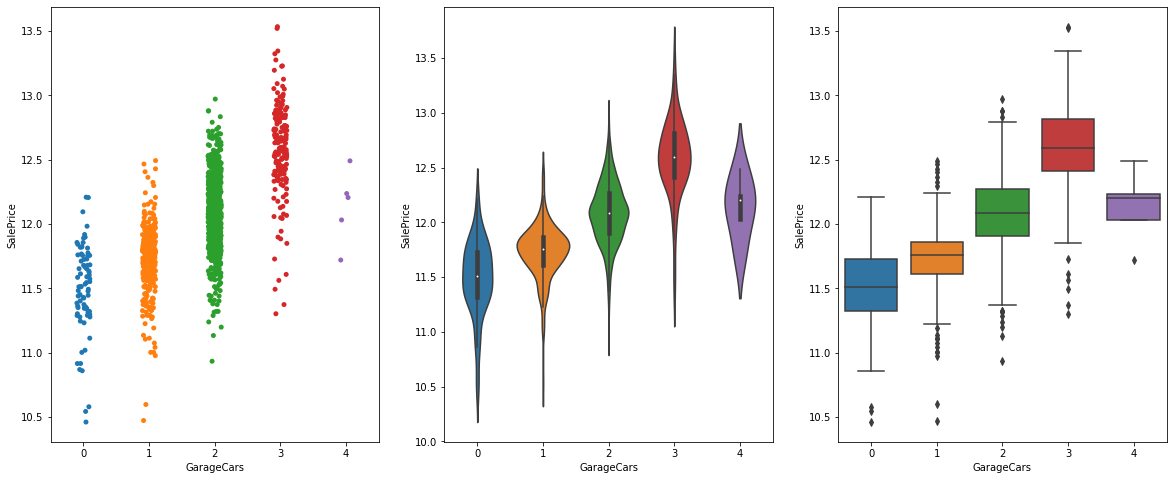

In [32]:
# GarageCars - SalePrice [corr = 0.68]

figure, ax = plt.subplots(1,3, figsize = (20,8))
sns.stripplot(data=train_data, x = 'GarageCars', y='SalePrice', ax = ax[0])
sns.violinplot(data=train_data, x = 'GarageCars', y='SalePrice', ax = ax[1])
sns.boxplot(data=train_data, x = 'GarageCars', y='SalePrice', ax = ax[2])
plt.show()

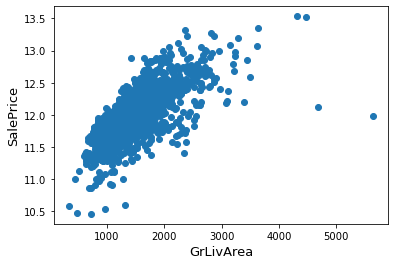

In [33]:
# GrLivArea - SalePrice [corr = 0.7]
fig, ax = plt.subplots()
ax.scatter(x = train_data['GrLivArea'], y = train_data['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

Here we analyzed the variables with the highest correlations, keeping the features with the highest correlation in our data.

## Regression Analysis: Using RandomSearchCV

#### Feature Engineering

In [34]:
# Feature Engineering
train_data['TotalSF'] = train_data['TotalBsmtSF'] + train_data['1stFlrSF'] + train_data['2ndFlrSF']
train_data['Bathrooms'] = train_data['FullBath'] + train_data['HalfBath'] * 0.5
train_data['YearAverage'] = (train_data['YearBuilt'] + train_data['YearRemodAdd']) / 2

# Feature Engineering Test Data
test_data['TotalSF'] = test_data['TotalBsmtSF'] + test_data['1stFlrSF'] + test_data['2ndFlrSF']
test_data['Bathrooms'] = test_data['FullBath'] + test_data['HalfBath'] * 0.5
test_data['YearAverage'] = (test_data['YearBuilt'] + test_data['YearRemodAdd']) / 2

We performed feature engineering to create new features that may help improve the performance of our machine learning model. The following features were engineered:  
  
1. TotalSF: This feature represents the total square footage of the house, which is the sum of the total basement square footage (TotalBsmtSF), the first floor square footage (1stFlrSF), and the second floor square footage (2ndFlrSF). The intuition behind creating this feature is that the total square footage of a house is often an important factor in determining its price.
  
2. Bathrooms: This feature represents the total number of bathrooms in the house. We calculated it by adding the number of full bathrooms (FullBath) and half the number of half bathrooms (HalfBath). The idea behind this feature is that the total number of bathrooms in a house can also be an important factor in determining its price, so we decided to combine to have a total bathroom count.
  
3. YearAverage: This feature represents the average of the year the house was built (YearBuilt) and the year the house was remodeled or had additions (YearRemodAdd). The motivation for creating this feature is to capture reflect a house's value after remodeling as this generally improves the house from the date it was built.

#### Data Preprocessing

In [35]:
# Define the column transformer
numeric_features = train_data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = train_data.select_dtypes(include=['object']).columns

# Update numerical_transformer to use CustomSimpleImputer
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# Update categorical_transformer to use CustomSimpleImputer
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Define columns to be dropped
drop_columns = ['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage']

# Remove drop_columns from numeric_features and categorical_features
numeric_features = [col for col in numeric_features if col not in drop_columns and col != 'SalePrice']
categorical_features = [col for col in categorical_features if col not in drop_columns]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

We used a fairly straightforward approach to preprocess our features to prepare it for machine learning models.  
  
  1. Determine how to handle numerical and categorical features. More specifically, we used SimpleImputer to impute nan values with the median and RobustScaler to standardize our numerical features. For our categorical data, we imputed the nan values with the mode using SimpleImputer and used OneHotEncoder to create dummy variables.
    
  2. Drop columns with too many Nan values ('Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage') and update our features.

  3. Create a ColumnTransformer object with our transformers for numerical and categorical features.

#### Model Stacking/Building Pipeline

In [36]:
# Model Stacking
estimators = [
    ('lgbm', LGBMRegressor(n_estimators=100, max_depth=3)),
    ('xgb', XGBRegressor(n_estimators=100, max_depth=3)),
    ('gbr', GradientBoostingRegressor(n_estimators=100, max_depth=3)),
    ('rfr', RandomForestRegressor(n_estimators=100, max_depth=3)),
    ('catboost', CatBoostRegressor(iterations=100, depth=4, learning_rate=0.1, silent=True))
]

stacking_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator=RidgeCV(alphas=np.logspace(-3, 3, 10))
)

Above, we used a model stacking technique to improve our model performance. This way we can combine the strengths of different models to create a more robust prediction.  
  
  1. Selecting Models: 
  - LightGBM: Gradient Boosting that uses tree-based learning algorithms. More specifically it uses a leaf-wise tree growth strategy.
  - XGBoost: Gradient Boosting that has built in regularization. Helps prevent overfitting.
  - Gradient Boosting Regressor: Sequentially builds weak learners and reduces the error at each step by focusing on the mishaps of previous iterations.
  - Random Forest Regressor: Uses large numbers of decision trees, combined to stabilize the prediction.
  - CatBoost: Gradient Boosting that is designed to handle categorical features
    
  2. Create a Stacking Regressor: Combining our base models we can use each of the predictions as inputs for the final estimator. The predictions are inputed into a Ridge Regression, a linear model that has built in cross validation, to generate our final predictions.

In [37]:
# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', stacking_regressor)
])

# Separate the train_data into training and validation sets
X = train_data.drop(['Id', 'SalePrice'], axis=1)
y = train_data['SalePrice']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameters for each of the base models and the final estimator
param_grid = {
    'regressor__lgbm__n_estimators': [50, 100, 150],
    'regressor__lgbm__max_depth': [2, 3, 4],
    'regressor__xgb__n_estimators': [50, 100, 150],
    'regressor__xgb__max_depth': [2, 3, 4],
    'regressor__gbr__n_estimators': [50, 100, 150],
    'regressor__gbr__max_depth': [2, 3, 4],
    'regressor__rfr__n_estimators': [50, 100, 150],
    'regressor__rfr__max_depth': [2, 3, 4],
    'regressor__catboost__iterations': [50, 100, 150],
    'regressor__catboost__depth': [2, 3, 4],
    'regressor__final_estimator__alphas': [np.logspace(-3, 3, 10)]
}


In [38]:
# Perform randomized search using 5-fold cross-validation
random_search = RandomizedSearchCV(pipeline, param_grid, n_iter=100, scoring = 'neg_mean_squared_error', cv=5, n_jobs=-1, verbose=1, random_state=42)
random_search.fit(X_train, y_train)

# Predict on the validation data using the best estimator
best_pipeline = random_search.best_estimator_
y_val_pred = best_pipeline.predict(X_val)

# Calculate RMSE and R^2 on the validation set
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
r2 = r2_score(y_val, y_val_pred)

print(f"Validation RMSE: {rmse:.4f}")
print(f"Validation R^2: {r2:.4f}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Validation RMSE: 0.1281
Validation R^2: 0.9120


Here we define our pipeline with the preprocessor and stacking regressor from before.
  
  1. Then we separated our train_data into training and validation sets and defined a range of hyperparameters to find the best combination of hyperparameters that minimizes the mean squared error of the predictions.
    
  2. We used RandomizedSearchCV, an alternative to GridSearchCV, to evaluate 100 random combination of hyperparameters using 5 folds for cross validation.
  We used the best performing pipeline to evaluate the model's performance.
    
  3. Using RMSE and R^2 score to evaluate the models performance, we got an R^2 = 0.9120 and RMSE = 0.1281.


In [39]:
# Print best parameters
print(random_search.best_params_)
print(random_search.best_score_)

{'regressor__xgb__n_estimators': 50, 'regressor__xgb__max_depth': 2, 'regressor__rfr__n_estimators': 100, 'regressor__rfr__max_depth': 4, 'regressor__lgbm__n_estimators': 100, 'regressor__lgbm__max_depth': 3, 'regressor__gbr__n_estimators': 150, 'regressor__gbr__max_depth': 4, 'regressor__final_estimator__alphas': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]), 'regressor__catboost__iterations': 150, 'regressor__catboost__depth': 4}
-0.015356393088845935


#### Predict 'SalePrice' using Test Data

We first need to preprocess test_data in the same way we did for train_data. We can do this by using the same pipeline and dropping strategy as before.

In [40]:
# Prepare the test_data
X_test = test_data.drop(['Id'], axis=1)

# Predict on the test data using the best estimator
y_test_pred = best_pipeline.predict(X_test)

# Apply the inverse log transformation to the predicted 'SalePrice' values
y_test_pred_original_scale = np.expm1(y_test_pred)

Finally, we take our best model and predict 'SalePrice' on the test data:
  
  1. First we preprocess the data the same way we did with the training data
  2. Predict 'SalePrice' on test data using the best pipeline
  3. Apply an inverse log transformation since we log transformed the original 'SalePrice' to train the model

#### Create Submission File

In [41]:
# Create the submission DataFrame
submission = pd.DataFrame({'Id': test_data['Id'], 'SalePrice': y_test_pred_original_scale})

# Save the submission DataFrame to a CSV file
submission.to_csv('submission_V2.csv', index=False)

### Screenshot of Best Kaggle Submission

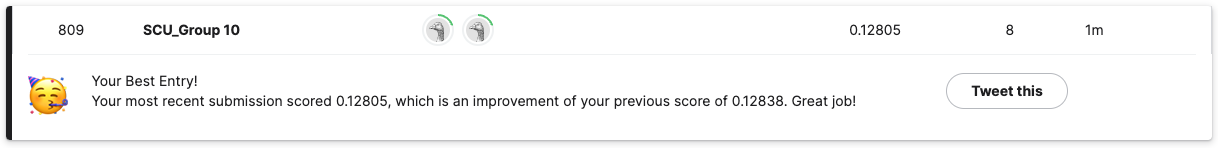

In [43]:
from IPython.display import Image
Image(filename = 'kaggle_screenshot_v2.png')